# Analysis of UQ runs
These notebooks will be used to plot data and data analysis for UQ runs for SOFE 2023.


## Run information

- baseline 2018
- pnetel is 400.
- Fixed rmajor to 9.0, the average of a previous uq run.
- Maximise Net Electric
- pheat turned on
- UQ bounds ~10%

## Import the Uncertainty Data and create object

## Calculate Sensitivity Indices and Reliability

In [1]:
%load_ext autoreload
%autoreload 1
from pathlib import Path
from bokeh.plotting import figure, show
import sys
sys.path.append('/home/graeme/process_uq/')
sys.path.append('/home/graeme/PROCESS_SALib/')
from uq_analysis import UncertaintyData, Copula, CopulaAnalysis
# from bokeh.plotting import figure 
from bokeh.io import output_notebook
output_notebook()

proj_dir = str(Path.cwd())+"/"
proj_dir = "/home/graeme/data/uq_run_data/paper_runs"
figure_of_merit = "powfmw"
uq_data = UncertaintyData(proj_dir, figure_of_merit)
print("number of converged samples:",len(uq_data.converged_df))



Loading BokehJS ...

number of converged samples: 130


In [2]:
uq_data.calculate_sensitivity(figure_of_merit)
uq_data.calculate_reliability()
# print("rmajor mean: ", round(uq_data.converged_df["rmajor"].mean(),2))
print("Number of samples: ", len(uq_data.uncertainties_df))
print(
    "Number of converged runs: ",
    uq_data.number_of_converged_runs,
)
print("Reliability: ", uq_data.reliability_index)


Number of samples:  2070
Number of converged runs:  130
Reliability:  0.06


## Regional Sensitivity - what causes PROCESS to converge?

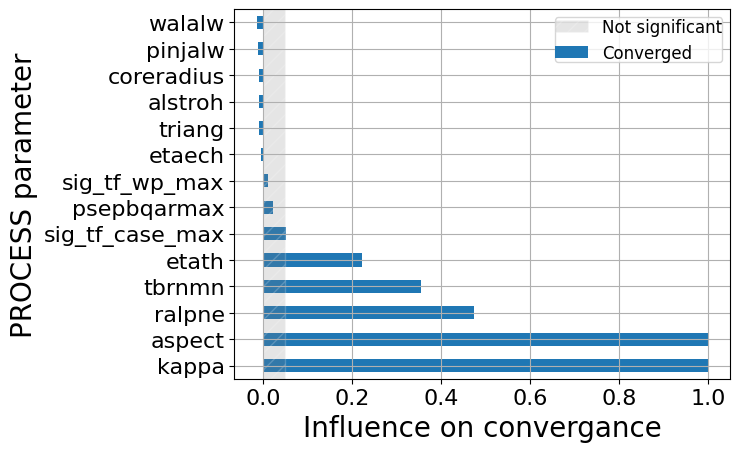

['kappa', 'aspect', 'ralpne', 'tbrnmn', 'etath', 'sig_tf_case_max']


In [3]:
uq_data.convergence_regional_sensitivity_analysis(uq_data.input_names)
uq_data.plot_sumsq_sensitivity()
significant_conv_vars = uq_data.find_significant_parameters(uq_data.sumsq_sensitivity_df,"unconverged",0.05).tolist()
print(significant_conv_vars)

## Find the iteration variables which are influential for the significant convergence variables

In [4]:
copula = Copula(uq_data.converged_df,significant_conv_vars,copula_type="bounded")
copula.calculate_copula(synthetic_sample_size=100000)
copula.calculate_pdf()
copula.copula_data_dict()
pdf_df=copula.create_pdf_df()
copula.find_max_pdf(print_data=False)
copula_correlation_matrix = copula.correlation_matrix()

/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)


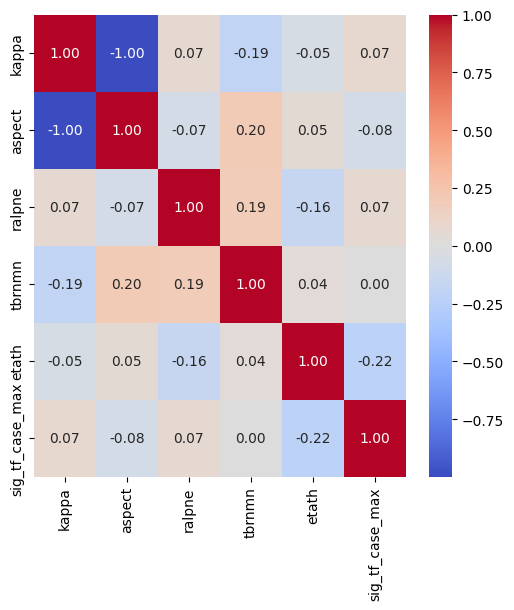

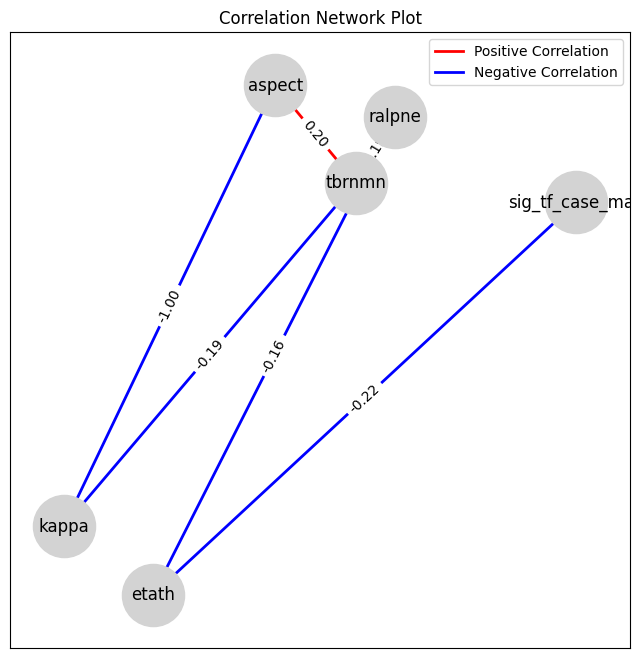

In [5]:
copula.plot_correlation_matrix(copula_correlation_matrix)
copula.plot_network(copula_correlation_matrix)

## Create a copula based on the important variables for convergence and iteration variables

In [6]:
all_variables = significant_conv_vars + ["sig_tf_case_max","sig_tf_wp_max","alstroh","rmajor",'bt', 'beta', 'jwptf', 'fcutfsu', 'plhthresh', 'wallmw', 'dene', 'ohcth', 'bore', 'coheof', 'powfmw', 'cohbop', 'te', 'bigq', 'tfcth', 'tdmptf', 'vtfskv']
vars_to_model = []
for item in all_variables:
    if item not in vars_to_model:
        vars_to_model.append(item)
print(vars_to_model)
itv_copula = Copula(uq_data.converged_df,vars_to_model, copula_type="bounded")
itv_copula.calculate_copula(synthetic_sample_size=1000000)
itv_copula.calculate_pdf()
itv_pdf_df=itv_copula.create_pdf_df()
itv_copula.copula_data_dict()


['kappa', 'aspect', 'ralpne', 'tbrnmn', 'etath', 'sig_tf_case_max', 'sig_tf_wp_max', 'alstroh', 'rmajor', 'bt', 'beta', 'jwptf', 'fcutfsu', 'plhthresh', 'wallmw', 'dene', 'ohcth', 'bore', 'coheof', 'powfmw', 'cohbop', 'te', 'bigq', 'tfcth', 'tdmptf', 'vtfskv']


/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/copulas/multivariate/gaussian.py:119: UserWarning: Unable to fit to a Univariate distribution for column kappa. Using a Gaussian distribution instead.
  warnings.warn(warning_message)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/copulas/multivariate/gaussian.py:119: UserWarning: Unable to fit to a Univariate distribution for column aspect. Using a Gaussian distribution instead.
  warnings.warn(warning_message)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/copulas/multivariate/gaussian.py:119: UserWarning: Unable to fit to a Univariate distribution for column ralpne. Using a Gaussian distribution instead.
  warnings.warn(warning_message)
/home/graeme/process_uq/uqenv/lib/python3.10/site-packages/copulas/multivariate/gaussian.py:119: UserWarning: Unable to fit to a Univariate distribution for column tbrnmn. Using a Gaussian distribution instead.
  warnings.warn(warning_message)
/home/graeme/process_uq/u

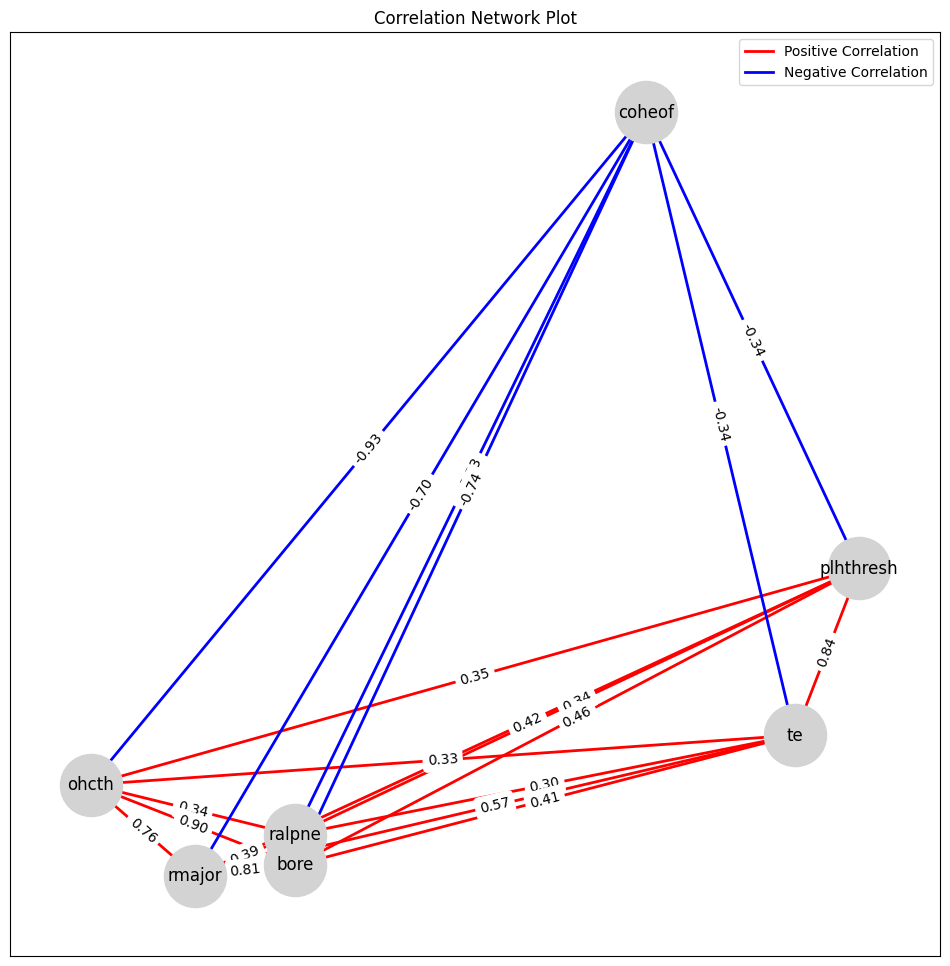

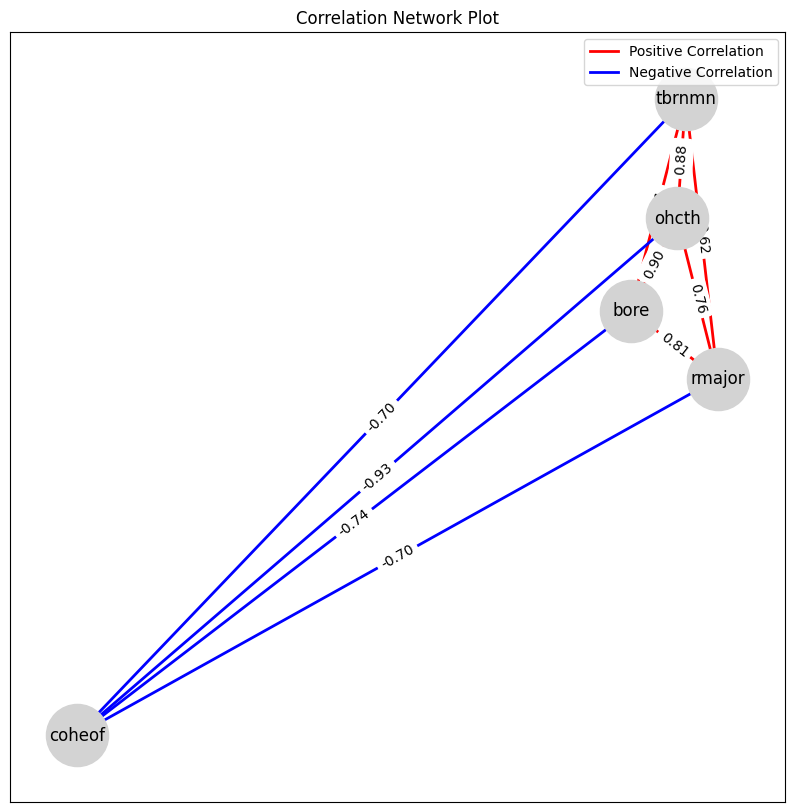

In [7]:
itv_correlation_matrix = itv_copula.correlation_matrix()
# itv_copula.plot_correlation_matrix(itv_correlation_matrix)
itv_copula.plot_network(itv_correlation_matrix,threshold=0.25,variables=["ralpne"],figsize=(12,12))
itv_copula.plot_network(itv_correlation_matrix,threshold=0.5,variables=["tbrnmn"],figsize=(10,10))

In [8]:
custom_data = {"aspect":3.0,"etath":0.375}
sens_plots=CopulaAnalysis(uq_data,copula,num_intervals=50)#,custom_data_point=custom_data)
show(sens_plots.create_graph_grid(significant_conv_vars))
show(sens_plots.create_datatable(significant_conv_vars))

In [9]:
custom_data = {"etath":0.370,"ralpne":0.07}
itv_plots=CopulaAnalysis(uq_data,itv_copula,num_intervals=30,custom_data_point=custom_data)
show(itv_plots.create_datatable(vars_to_model))